In [1]:
import numpy as np
import pyworld as pw
import librosa
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as display
import os

In [2]:
def plot_mel(data, stats, titles):
    fig, axes = plt.subplots(len(data), 1, squeeze=False)
    if titles is None:
        titles = [None for i in range(len(data))]
    pitch_min, pitch_max, pitch_mean, pitch_std, energy_min, energy_max = stats
    pitch_min = pitch_min * pitch_std + pitch_mean
    pitch_max = pitch_max * pitch_std + pitch_mean

    def add_axis(fig, old_ax):
        ax = fig.add_axes(old_ax.get_position(), anchor="W")
        ax.set_facecolor("None")
        return ax

    for i in range(len(data)):
        mel, pitch, energy = data[i]
        pitch = pitch * pitch_std + pitch_mean
        axes[i][0].imshow(mel, origin="lower")
        axes[i][0].set_aspect(4.5, adjustable="box")
        axes[i][0].set_ylim(0, mel.shape[0])
        axes[i][0].set_title(titles[i], fontsize="medium")
        axes[i][0].tick_params(labelsize="x-small", left=False, labelleft=False)
        axes[i][0].set_anchor("W")

        ax1 = add_axis(fig, axes[i][0])
        ax1.plot(pitch, color="tomato")
        ax1.set_xlim(0, mel.shape[1])
        ax1.set_ylim(0, pitch_max)
        ax1.set_ylabel("F0", color="tomato")
        ax1.tick_params(
            labelsize="x-small", colors="tomato", bottom=False, labelbottom=False
        )
    return fig

orig


Text(0.5, 1.0, 'spectrogram')

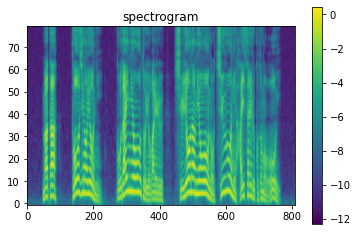

In [4]:
WAV_FILE =  # write your file
data, fs = librosa.load(WAV_FILE, sr = 24000)
data = data.astype(np.float64)  # WORLDはfloat前提のコードになっているのでfloat型にしておく
print('orig')
display.display(
    display.Audio(data, rate=fs)
)

audio = torch.from_numpy(data).to(torch.float32)

spec_module = torchaudio.transforms.Spectrogram(
    win_length=1024,
    n_fft=1024,
    hop_length=256,
    power=1,
    center=True,
)

mel_scale = torchaudio.transforms.MelScale(
    n_mels=80,
    sample_rate=fs,
    f_min=0,
    f_max=8000,
    n_stft=1024 // 2 + 1,
    norm="slaney",
    mel_scale="slaney",
)
magspec = spec_module(audio)
melspec = mel_scale(magspec)
plt.figure()
show_mcep = np.log(melspec+1e-15).T
plt.imshow(show_mcep.T, aspect=show_mcep.shape[0]/show_mcep.shape[1]/1.5, origin='lower')
plt.colorbar()
plt.title('spectrogram')

## スペクトログラムと基本周波数を重ねて表示

In [7]:
pitch, t = pw.harvest(data, fs, frame_period=256 / fs * 1000,)  # ここを予測した基本周波数で置き換える
energy = magspec.sum(axis=0).cpu().numpy()
pitch_min = pitch.min()
pitch_max = 4000
pitch_mean = 0
pitch_std = 1
energy_min = energy.min()
energy_max = energy.max()
stats = [pitch_min, pitch_max, pitch_mean, pitch_std, energy_min, energy_max]

In [8]:
pitch.shape

(809,)

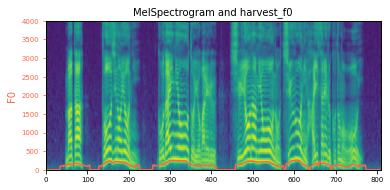

In [6]:
fig = plot_mel(
    [
        (torch.log(melspec).cpu().numpy(), pitch, energy),
    ],
    stats,
    ["MelSpectrogram and harvest_f0"],
)